<h1><center>FINDING GOOD SCHOOLS</center></h1> 

The objective of the analysis is to find possible schools for our daughter. We've determined potential relocation areas, since we are renting at the time, and scraped data from greatschools.org which is a website that contains information about school ratings, test scores, and school size, among others.

First, we will explore, clean, and format the data. We'll try to discover patterns or relationships between the features of the schools. 

After that, we will focus on finding the best schools based on the criteria we determined to be relevant for our case.


## SETUP

In [82]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import geopy.distance
import folium 

from scipy.stats import norm
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from branca.element import Figure # To set the size of the map
from sklearn.linear_model import LogisticRegression



In [101]:
# Define functions
def mult_plot(ax, title, text):
    ax.set_xlabel('', fontsize=9)
    ax.set_ylabel('', fontsize=9)
    ax.set_title(title, fontsize=12)
    if text == True:
        ax.bar_label(container=ax.containers[0], fontsize=6, padding=1)
    #ax.set_yticks([0,100,200,300])
    #ax.set_ylim(0,300)
    #ax.set_xticklabels(schools_df['school_rating'].unique(), rotation=45, horizontalalignment='right')

def get_levels(dataf):
    pre_k_df = dataf.loc[dataf['pre_k_school'] == True]
    elementary_df = dataf.loc[dataf['elementary_school'] == True]
    middle_df = dataf.loc[dataf['middle_school'] == True]
    high_df = dataf.loc[dataf['high_school'] == True]

    return pre_k_df, elementary_df, middle_df, high_df

## LOADING DATA

In [9]:
# Load scraped data
cities = ['Lakewood',
          'Cerritos',
          'LongBeach',
          'Bellflower',
          'Norwalk',
          'Downey',
          'Whittier',
          'LosAlamitos',
          'Cypress',
          'SantaFeSprings']

schools_df = pd.DataFrame()
schools_per_city_df = pd.DataFrame()
for city in cities:
    schools_per_city_df = pd.read_csv('data/schoolsOf' + city + '.csv')
    # Add city column
    schools_per_city_df.insert(loc=1,column='city', value=city, allow_duplicates=True)
    schools_df = pd.concat([schools_df, schools_per_city_df], ignore_index=True)

demographics_df = pd.DataFrame()
for city in cities:
    demographics_df = pd.concat([demographics_df,pd.read_csv('data/DemoInfoOf' + city + '.csv')], ignore_index=True)   

test_scores_df = pd.DataFrame()
for city in cities:
    test_scores_df = pd.concat([test_scores_df,pd.read_csv('data/TestScoresOf' + city + '.csv')], ignore_index=True)  
    
schools_df.drop(columns='Unnamed: 0', inplace=True)
demographics_df.drop(columns='Unnamed: 0', inplace=True)
test_scores_df.drop(columns='Unnamed: 0', inplace=True)

# Rename feature school rating to school_rating to match the format of the other features
schools_df.rename(columns={'school rating':'school_rating'}, inplace=True)

## DATASET OVERVIEW

Getting to know the data

In [5]:
# First look at the data
schools_df.head()

,city,school_name,school_rating,school_address,school_url,school_type,school_grades,school_total_students,school_teacher_ratio,school_district
0,Lakewood,Cleveland Elementary School,9\n/10,"4760 Hackett Avenue, Lakewood, CA, 90713",https://www.greatschools.org/california/lakewo...,Public district,K-5,469.0,21:1,Long Beach Unified School District
1,Lakewood,Odyssey Stem Academy,8\n/10,"3701 Michelson Street, Lakewood, CA, 90712",https://www.greatschools.org/california/lakewo...,Public district,9-12,136.0,NaN,Paramount Unified School District
2,Lakewood,Stephen Foster Elementary School,7\n/10,"5223 Bigelow Street, Lakewood, CA, 90712",https://www.greatschools.org/california/lakewo...,Public district,K-6,688.0,30:1,Bellflower Unified School District
3,Lakewood,Gompers K-8,7\n/10,"5206 Briercrest Avenue, Lakewood, CA, 90713",https://www.greatschools.org/california/lakewo...,Public district,K-8,700.0,24:1,Long Beach Unified School District
4,Lakewood,Holmes Elementary School,7\n/10,"5020 Barlin Avenue, Lakewood, CA, 90712",https://www.greatschools.org/california/lakewo...,Public district,K-5,383.0,20:1,Long Beach Unified School District


In [9]:
test_scores_df.head()

,school_name,subject_name,subject_score
0,Cleveland Elementary School,English,77%
1,Cleveland Elementary School,Math,65%
2,Cleveland Elementary School,Science,41%
3,Odyssey Stem Academy,English,77%
4,Odyssey Stem Academy,Math,14%


In [10]:
demographics_df.head()

,school_name,race,race_score
0,Cleveland Elementary School,Hispanic,41%
1,Cleveland Elementary School,White,34%
2,Cleveland Elementary School,Black,6%
3,Cleveland Elementary School,Two or more races,6%
4,Cleveland Elementary School,Filipino,5%


In [11]:
# Features of school dataset
schools_df.columns

Index(['city', 'school_name', 'school_rating', 'school_address', 'school_url',
       'school_type', 'school_grades', 'school_total_students',
       'school_teacher_ratio', 'school_district'],
      dtype='object')

In [12]:
# How many schools will we be analyzing?
print('Total schools:', schools_df.shape[0])

Total schools: 663


In [13]:
# From how many cities do we have information?
print("From", len(schools_df['city'].unique()), "cities:")
print(' \n'.join(schools_df['city'].unique()))

From 10 cities:
Lakewood 
Cerritos 
LongBeach 
Bellflower 
Norwalk 
Downey 
Whittier 
LosAlamitos 
Cypress 
SantaFeSprings


In [16]:
# How many school districts are included?
print('From', len(schools_df['school_district'].unique()), 'school districts:')
print('\n'.join(schools_df['school_district'].unique().astype('str')))

From 27 school districts:
Long Beach Unified School District
Paramount Unified School District
Bellflower Unified School District
Abc Unified School District
nan
Intellectual Virtues Academy of Long Beach District
Los Angeles Unified School District
Intellectual Virtues Academy District
Long Beach Unified Rop School District
The Education Corps District
Clear Passage Educational Center District
California Advancing Pathways For Students In Los Angeles County Roc P School District
Little Lake City Elementary School District
Norwalk-La Mirada Unified School District
Downey Unified School District
Los Angeles County Office Of Education School District
Los Angeles County Rop School District
East Whittier City Elementary School District
Whittier Union High School District
Lowell Joint School District
Whittier City Elementary School District
Los Nietos School District
South Whittier Elementary School District
Tri-Cities Rop School District
Los Alamitos Unified School District
Anaheim Union H

In [17]:
# What type of schools?
aux = schools_df['school_type'].unique()
print('There are', ', '.join(aux), 'schools')

There are Public district, Private, Public charter schools


In [18]:
# Which grades are included in the schools we are analyzing?
aux = schools_df['school_grades'].unique()
print('The grades included are', ', '.join(aux))


The grades included are K-5, 9-12, K-6, K-8, 7-12, 6-8, PK-3, PK, PK-K, K-12, 7-8, Ungraded, K, PK-5, 7, PK-12, 1-12, 6-12, PK-1, K-3, PK-6, 10-12, K, 4-5, 7-8, PK-5, PK-8, PK-2, 1-4, K-2, 11-12, K-11, K-9, PK-10, K-4, 8-12, 1-11, 3-12, K-4, 6, 8-9, 11-12, 4-5, 1-5, 7-11, PK-7, 1-8, PK-4


In [19]:
# How have the schools been rated?
schools_df['school_rating'].unique()


array(['9\n/10', '8\n/10', '7\n/10', '6\n/10', '5\n/10', '4\n/10',
       'Unrated', '10\n/10', '3\n/10', '2\n/10'], dtype=object)

In [20]:
# What are the 'school_teacher_ratio' values?
schools_df['school_teacher_ratio'].unique()

array(['21:1', nan, '30:1', '24:1', '20:1', '25:1', '22:1', '27:1',
       '19:1', '23:1', '32:1', '26:1', '9:1', '29:1', '68:1', '15:1',
       '18:1', '12:1', '34:1', '13:1', '14:1', '31:1', '28:1', '4:1',
       '17:1', '16:1', '7:1', '6:1', '8:1', '1:1', '11:1', '64:1'],
      dtype=object)

In [21]:
# For which subjects there is test score data?
aux = test_scores_df['subject_name'].unique()
print('The subjects for which we have data are', ', '.join(aux))

The subjects for which we have data are English , Math , Science 


In [22]:
# How many schools have data about test scores?
aux = len(test_scores_df['school_name'].unique())
print('The schools for which we have test score data are', aux)

The schools for which we have test score data are 231


## DATA WRANGLING

We will analyze missing values, perform data binning, change the format of some of the features, and create others to allow further analysis of the data.

IDENTIFY AND REMOVE DUPLICATE SCHOOLS 

In [23]:
# Find duplicate schools
aux = schools_df['school_name'].value_counts()[lambda x: x>1].index
schools_df.loc[schools_df['school_name'].isin(aux)].sort_values(by=['school_name'])

,city,school_name,school_rating,school_address,school_url,school_type,school_grades,school_total_students,school_teacher_ratio,school_district
634,Cypress,Aslan Academy,Unrated,"9080 Bloomfield Avenue, Cypress, CA, 90630",https://www.greatschools.org/california/cypres...,Private,1-12,NaN,NaN,NaN
622,Cypress,Aslan Academy,Unrated,"9734 Paseo De Oro, Cypress, CA, 90630",https://www.greatschools.org/california/cypres...,Private,1-12,NaN,NaN,NaN
441,Downey,Creative Beginnings,Unrated,"10910 Paramont Blvd, Downey, CA, 90241",https://www.greatschools.org/california/downey...,Private,K-5,NaN,NaN,NaN
227,LongBeach,Creative Beginnings,Unrated,"5600 Linden Avenue, Long Beach, CA, 90805",https://www.greatschools.org/california/long-b...,Private,PK,NaN,NaN,NaN
426,Downey,Creative Beginnings,Unrated,"8033 3rd Street, Downey, CA, 90241",https://www.greatschools.org/california/downey...,Private,K-6,124.0,NaN,NaN
459,Downey,Downey Christian School,Unrated,"8219 Florence Avenue, Downey, CA, 90240",https://www.greatschools.org/california/downey...,Private,PK-8,177.0,NaN,NaN
435,Downey,Downey Christian School,Unrated,"10335 Paramount Boulevard, Downey, CA, 90241",https://www.greatschools.org/california/downey...,Private,K-8,80.0,NaN,NaN
55,Cerritos,Fecc Children Academy,Unrated,"11330 E 166th St, Cerritos, CA, 90703",https://www.greatschools.org/california/cerrit...,Private,PK-K,15.0,NaN,NaN
68,Cerritos,Fecc Children Academy,Unrated,"11330 166th Street, Cerritos, CA, 90703",https://www.greatschools.org/california/cerrit...,Private,PK-K,NaN,NaN,NaN
297,LongBeach,Huntington Academy,Unrated,"1423 Walnut Avenue, Long Beach, CA, 90813",https://www.greatschools.org/california/long-b...,Private,PK-5,47.0,NaN,NaN


In [10]:
# Remove duplicate schools
# There are many different cases for duplicates, so I'm dropping them manually
duplicate_schools = [634, 622, 441, 435, 68, 297, 316, 467, 458, 396, 393, 428, 292, 22, 19, 71]
schools_df.drop(duplicate_schools,axis=0, inplace=True)

schools_df.loc[227,'school_name'] = 'YMCA Creative Beginnings'
#aux = schools_df.drop_duplicates(subset=['school_name','city'])

In [25]:
# Number of schools
schools_df.shape[0]

647

MERGE TEST SCORE DATASET WITH SCHOOL DATASET

In [11]:
# Reshape test_score dataset to merge it with the school dataset
scores_df = pd.pivot_table(test_scores_df, values='subject_score', columns='subject_name', index=['school_name'],aggfunc='first').rename_axis(None,axis=1).reset_index() #index =['datetime'], columns =['school_name'], aggfunc=lambda x: x
scores_df.columns = scores_df.columns.str.strip()
scores_df.head()

,school_name,English,Math,Science
0,A. E. Arnold Elementary School,64%,61%,43%
1,ABC Secondary (Alternative) School,22%,5%,5%
2,Ada S. Nelson Elementary School,55%,45%,32%
3,Addams Elementary School,34%,27%,18%
4,Aeolian Elementary School,42%,24%,19%


In [12]:
# Merge schools_df with scores_df
schools_df = schools_df.merge(scores_df, how='left', on='school_name')
schools_df.head()    

,city,school_name,school_rating,school_address,school_url,school_type,school_grades,school_total_students,school_teacher_ratio,school_district,English,Math,Science
0,Lakewood,Cleveland Elementary School,9\n/10,"4760 Hackett Avenue, Lakewood, CA, 90713",https://www.greatschools.org/california/lakewo...,Public district,K-5,469.0,21:1,Long Beach Unified School District,77%,65%,41%
1,Lakewood,Odyssey Stem Academy,8\n/10,"3701 Michelson Street, Lakewood, CA, 90712",https://www.greatschools.org/california/lakewo...,Public district,9-12,136.0,NaN,Paramount Unified School District,77%,14%,44%
2,Lakewood,Stephen Foster Elementary School,7\n/10,"5223 Bigelow Street, Lakewood, CA, 90712",https://www.greatschools.org/california/lakewo...,Public district,K-6,688.0,30:1,Bellflower Unified School District,57%,44%,43%
3,Lakewood,Gompers K-8,7\n/10,"5206 Briercrest Avenue, Lakewood, CA, 90713",https://www.greatschools.org/california/lakewo...,Public district,K-8,700.0,24:1,Long Beach Unified School District,52%,45%,25%
4,Lakewood,Holmes Elementary School,7\n/10,"5020 Barlin Avenue, Lakewood, CA, 90712",https://www.greatschools.org/california/lakewo...,Public district,K-5,383.0,20:1,Long Beach Unified School District,51%,43%,24%


MISSING VALUES

In [30]:
# How many missing values per column in school dataset?
missing_values_count = schools_df.isnull().sum()
missing_values_count

city                       0
school_name                0
school_rating              0
school_address             0
school_url                 0
school_type                0
school_grades              0
school_total_students    270
school_teacher_ratio     413
school_district          401
English                  416
Math                     416
Science                  423
dtype: int64

In [31]:
# How many total missing values do we have in the school dataset?
total_cells = np.product(schools_df.shape)
total_missing = missing_values_count.sum()
	
# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print("Percentage of missing values: %.2f" % (percent_missing))

Percentage of missing values: 27.81


Let's analyze missing values in regard to school_type (Private and Public schools)

In [32]:
# Missing values for private schools
private_s_df  = schools_df.loc[schools_df['school_type'] == 'Private']
public_s_df   = schools_df.loc[schools_df['school_type'] != 'Private']
print("Number of private schools:", private_s_df.shape[0],"\n",
      "Missing values:\n", private_s_df.isnull().sum())

missing_values_count = private_s_df.isnull().sum()
total_cells = np.product(private_s_df.shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print("Percentage of missing values: %.2f" % (percent_missing))

Number of private schools: 401 
 Missing values:
 city                       0
school_name                0
school_rating              0
school_address             0
school_url                 0
school_type                0
school_grades              0
school_total_students    261
school_teacher_ratio     401
school_district          401
English                  401
Math                     401
Science                  401
dtype: int64
Percentage of missing values: 43.47


None of the 401 private schools have information about teacher-student ratio, school district, and test scores, and 261 of them don't have information about total students.

It is important to notice that this doesn't identify values such as 'Ungraded' or 'Unrated' which are included in many features.

In [33]:
# Missing values for public schools
print("Number of public schools:", public_s_df.shape[0],"\n",
      "Missing values: \n", public_s_df.isnull().sum())

missing_values_count = public_s_df.isnull().sum()
total_cells = np.product(public_s_df.shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print("Percentage of missing values: %.2f" % (percent_missing))      

Number of public schools: 246 
 Missing values: 
 city                      0
school_name               0
school_rating             0
school_address            0
school_url                0
school_type               0
school_grades             0
school_total_students     9
school_teacher_ratio     12
school_district           0
English                  15
Math                     15
Science                  22
dtype: int64
Percentage of missing values: 2.28


There are 246 public schools and less than 3% have missing values. 

In [13]:
# Remove rows with no information about total students, teacher student ratio, school grades and school rating
aux = schools_df[schools_df['school_total_students'].isnull() & 
              schools_df['school_teacher_ratio'].isnull() &
             (schools_df['school_grades'] == 'Ungraded') & 
             (schools_df['school_rating'] == 'Unrated')].index
schools_df.drop(aux, inplace=True)


In [14]:
# Drop Adult schools_df because we are not interested
aux = schools_df.loc[schools_df['school_name'].str.contains('adult', case=False, regex = False)].index
schools_df.drop(aux, inplace=True)

In [15]:
# Drop rows with special cases because we are not interested
aux = schools_df.loc[schools_df['school_name'].str.contains('Preparatory', case=False, regex = False)].index
schools_df.drop(aux, inplace=True)

aux = schools_df.loc[(schools_df['school_district'] == 'Long Beach Unified Rop School District') | 
                     (schools_df['school_district'] == 'The Education Corps District') |
                     (schools_df['school_district'] == 'Clear Passage Educational Center District') |
                     (schools_df['school_district'] == 'California Advancing Pathways For Students In Los Angeles County Roc P School District') |
                     (schools_df['school_district'] == 'Los Angeles County Office Of Education School District') |
                     (schools_df['school_district'] == 'Los Angeles County Rop School District') |
                     (schools_df['school_district'] == 'Tri-Cities Rop School District')].index
schools_df.drop(aux, inplace=True)


In [16]:
# Analyzing missing values for the feature school_district
aux = schools_df.loc[schools_df['school_district'].isnull()]
aux['school_type'].unique()

array(['Private'], dtype=object)

The feature school district has missing values only for Private schools, we will replace nan values with "Private".

In [17]:
# Assign value 'Private' to missing values in school_district
schools_df['school_district'] = schools_df['school_district'].apply(lambda x: 'Private' if pd.isna(x) else x)

In [18]:
# Correct misspelled school districts
schools_df.loc[82,'school_district'] = 'Long Beach Unified School District'
schools_df.loc[141,'school_district'] = 'Long Beach Unified School District'

In [19]:
# Replace nan values for 'school_teacher_ratio' with "Unknown"
schools_df['school_teacher_ratio'].fillna("Unknown", inplace = True)

CREATING LEVELS BASED ON SCHOOL GRADES

Because the grades included in each school vary greatly, we will create four new grouping features that will facilitate the analysis: 
- pre_k_school
- elementary_school
- middle_school
- high_school

The grades included in each category vary depending on the school district.

When the school grade contains K, we will do a special analysis and include it either on Pre-K schools or Elementary schools, depending on the case.

Schools could belong to more than one category if they have grades contained in more than one category. 

In [20]:
# Group school grades in levels

def new_levels(row):
    # Define segments
    if row['school_district'] in ['Long Beach Unified School District',
                                  'Paramount Unified School District',
                                  'Little Lake City Elementary School District',
                                  'Norwalk-La Mirada Unified School District',
                                  'Downey Unified School District',
                                  'Whittier City Elementary School District',
                                  'Los Alamitos Unified School District']:
        pre_k_grade = ['PK']
        kinder = ['K']
        elementary_grades = ['1','2','3','4','5']
        middle_grades = ['6','7','8']
        high_school_grades = ['9','10','11','12']
    elif row['school_district'] in ['Bellflower Unified School District',
                                    'Abc Unified School District',
                                    'Cypress Elementary School District']:
        pre_k_grade = ['PK']
        kinder = ['K']
        elementary_grades = ['1','2','3','4','5','6']
        middle_grades = ['7','8']
        high_school_grades = ['9','10','11','12']
    elif row['school_district'] in ['East Whittier City Elementary School District',
                                    'Lowell Joint School District',
                                    'Los Nietos School District',
                                    'South Whittier Elementary School District']:
        pre_k_grade = ['PK']
        kinder = ['K']
        elementary_grades = ['1','2','3','4','5','6','7','8']
        middle_grades = []
        high_school_grades = ['9','10','11','12']
    else: # Only high schools districts Anaheim Union High School District, Whittier Union High School District, and Private Schools
        pre_k_grade = ['PK']
        kinder = ['K']
        elementary_grades = ['1','2','3','4','5']
        middle_grades = ['6','7','8']
        high_school_grades = ['9','10','11','12']

    
    # Creating multiple boolean variables because a school can include multiple levels 
    row['pre_k_school']      = False
    row['elementary_school'] = False
    row['middle_school']     = False
    row['high_school']       = False
    
    # parse
    levels = row['school_grades'].split(',')
    #for index,row in levels.iterrows():
    for i,j in enumerate(levels):
        if levels[i] != None:
            try:
                a , b = levels[i].split(sep='-')
            except:
                a = levels[i]
                b = levels[i]

            a = a.strip()
            b = b.strip()

            if a in pre_k_grade:
                row['pre_k_school']      = True
            # If in the split, the K appears on the right side (a) it means it is a school that begins in Kinder and has superior grades, so we include the school as an elementary school
            elif (a in kinder) & (a != b):
                row['elementary_school'] = True  
            elif a in elementary_grades:
                row['elementary_school'] = True
            elif a in middle_grades:
                row['middle_school']     = True
            elif a in high_school_grades:
                row['high_school']       = True

            # If in the split, the K appears on the left side (b) it means it is a school that ends in Kinder, so we include the school as pre-k school
            if b in pre_k_grade:
                row['pre_k_school'] = True
            elif b in kinder:
                row['pre_k_school'] = True
            elif b in elementary_grades:
                row['elementary_school'] = True
            elif b in middle_grades:
                row['middle_school'] = True
            elif b in high_school_grades:
                row['high_school']       = True

        # Special case: when the range includes levels that are not consecutive 
        if (row['pre_k_school'] == True & row['middle_school'] == True):
            row['elementary_school'] = True   

        if (row['elementary_school'] == True & row['high_school'] == True):
            row['middle_school'] = True  

        if (row['pre_k_school'] == True & row['high_school'] == True):
            row['elementary_school'] = True 
            row['middle_school'] = True  
         
    #try:
    #    a, b = levels.split('-', 1) #row['school_grades'].split('-', 1)
    #except:
    #    a = row['school_grades']
    #    b = row['school_grades']

     
    return row
    
schools_df = schools_df.apply(new_levels, axis='columns')

RE-FORMATING SCHOOL RATING

In [21]:
# Change format of school rating for the ones that have a value
schools_df['num'] = schools_df['school_rating'].str.partition("\n/")[0]
schools_df['school_rating'] = schools_df['num'] #schools_df['num'].apply(lambda x: pd.to_numeric(x) / 10 if x != 'Unrated' else x) 
schools_df.drop(columns=['num'], inplace=True)
schools_df['school_rating']

0            9
1            8
2            7
3            7
4            7
        ...   
642    Unrated
643    Unrated
644    Unrated
645    Unrated
646    Unrated
Name: school_rating, Length: 628, dtype: object

CREATING RATIO BINS TO GROUP TEACHER STUDENT RATIOS

In [22]:
# Group school_teacher_ratio in a new feature called ratio_bins
def ratio_bins_func (row):
    #parse
    if row['school_teacher_ratio'] != 'Unknown':
        row['ratio'] = pd.to_numeric(row['school_teacher_ratio'].partition(":")[0])
    else:
        row['ratio'] = 'Unknown'

    if row['ratio'] == 'Unknown':
        row['ratio_bins'] = 'Unknown'
    elif row['ratio'] <= 9:
        row['ratio_bins'] = '<10'
    elif row['ratio'] <= 15:
        row['ratio_bins'] = '10-15'
    elif row['ratio'] <= 20:
        row['ratio_bins'] = '16-20'
    elif row['ratio'] <= 30:
        row['ratio_bins'] = '21-30'
    else:
        row['ratio_bins'] = '30+'

    return row

    
schools_df = schools_df.apply(ratio_bins_func, axis='columns')

schools_df.drop(columns=['ratio'], inplace=True)


CONVERTING TEST SCORES TO NUMERIC

In [23]:
# Replace symbols and convert
schools_df['English']= schools_df['English'].str.replace('%','')
schools_df['English']= schools_df['English'].apply(lambda x: pd.to_numeric(x))
schools_df['Math']= schools_df['Math'].str.replace('%','')
schools_df['Math']= schools_df['Math'].str.replace('<','')
schools_df['Math']= schools_df['Math'].apply(lambda x: pd.to_numeric(x))
schools_df['Science']= schools_df['Science'].str.replace('%','')
schools_df['Science']= schools_df['Science'].str.replace('<','')
schools_df['Science']= schools_df['Science'].apply(lambda x: pd.to_numeric(x))

CORRECTING SCHOOL ADDRESS 

In [24]:
# Correcting addresses that fail to obtain lat, lon
schools_df.loc[250,'school_address'] = '5431 E Ocean Blvd., Long Beach, CA, 90803'
schools_df.loc[78,'school_address'] = '101 Venetia Dr, Long Beach, CA, 90803'
schools_df.loc[557,'school_address'] = '7056 Washington Avenue, Whittier, CA, 90602'
schools_df.loc[74,'school_address'] = '5808 E Marita St, Long Beach, CA, 90815'
schools_df.loc[86,'school_address'] = '3055 Rutgers Ave, Long Beach, CA 90808'
schools_df.loc[36,'school_address'] = '13418 Moore St, Cerritos, CA 90703'
schools_df.loc[49,'school_address'] = '13418 Moore St, Cerritos, CA 90703'
schools_df.loc[84,'school_address'] = '3684 Karen Ave, Long Beach, CA 90808'
schools_df.loc[96,'school_address'] = '2159 Rutgers Ave, Long Beach, CA 90815'
schools_df.loc[131,'school_address'] = '2159 Rutgers Ave, Long Beach, CA 90815'
schools_df.loc[323,'school_address'] = '9243 Laurel St, Bellflower, CA 90706'
schools_df.loc[366,'school_address'] = '13432 Halcourt Ave., Norwalk, CA, 90650'
schools_df.loc[414,'school_address'] = '8236 Lankin St, Downey, CA, 90242'
schools_df.loc[418,'school_address'] = '9403 Borson St, Downey, CA 90242'
schools_df.loc[421,'school_address'] = '9403 Borson St, Downey, CA 90242'
schools_df.loc[438,'school_address'] = '9403 Borson St, Downey, CA 90242'
schools_df.loc[471,'school_address'] = '8324 Millergrove Dr, Whittier, CA 90606'
schools_df.loc[494,'school_address'] = '10001 Carmenita Rd, Whittier, CA 90605'
schools_df.loc[507,'school_address'] = '8324 Millergrove Dr, Whittier, CA 90606'
schools_df.loc[577,'school_address'] = '10319 Los Alamitos Blvd, Los Alamitos, CA 90720'
schools_df.loc[579,'school_address'] = '12521 Kensington Rd, Rossmoor, CA 90720'
schools_df.loc[584,'school_address'] = '10261 Mardel Dr, Cypress, CA 90630'
schools_df.loc[193,'school_address'] = '3041 Delta Ave, Long Beach, CA, 90810'

FINDING LATITUD AND LONGITUD VALUES FOR EACH SCHOOL

In [ ]:
# Get latitud and longitud values for each school

# Initialize Nominatim into geolocator variable
geolocator = Nominatim(user_agent='schools')

# Apply geolocator.geocode to the address column
schools_df['locat'] = schools_df['school_address'].apply(geolocator.geocode)
# Get .point containing latitude and longitude from the geocode’s response, if it’s not None
schools_df['point']= schools_df['locat'].apply(lambda locat: tuple(locat.point) if locat else None)
# Split the .point into separate columns 'lat' 'lon' and 'altitude'
schools_df[['lat', 'lon', 'altitude']] = pd.DataFrame(schools_df['point'].to_list(), index=schools_df.index)
#except:
#    schools_df['locat'] = ''
#    schools_df['point']= ''
#    schools_df[['lat', 'lon', 'altitude']] = ''


schools_df.drop(columns=['locat','point'], inplace=True)
# Dump location data
#schools_df[['school_name','city','lat','lon','altitude']].to_csv("data/LocationInfo.csv")

In [25]:
# OR Load location data from file
locations_df = pd.read_csv('data/LocationInfo.csv')
#schools_df = schools_df.drop_duplicates(subset=['school_name','city'])
#locations_df = locations_df.drop_duplicates(subset=['school_name','city'])

schools_df = schools_df.merge(locations_df, how='inner', on=['school_name','city'])

schools_df.drop(columns='Unnamed: 0', inplace=True)


In [7]:
# Reshape demographic dataset to join it with the school dataset
demo_df = pd.pivot_table(demographics_df, values='race_score', columns='race', index=['school_name'],aggfunc='first').rename_axis(None,axis=1).reset_index() #index =['datetime'], columns =['school_name'], aggfunc=lambda x: x

demo_df.columns = demo_df.columns.str.strip()
# Final dataset
demo_df.head()

,school_name,Asian,Black,Filipino,Hispanic,Native American,Pacific Islander,Two or more races,Unspecified,White
0,A. E. Arnold Elementary School,32%,6%,5%,29%,<1%,<1%,3%,NaN,25%
1,ABC Secondary (Alternative) School,4%,11%,5%,74%,NaN,NaN,1%,NaN,5%
2,Ada S. Nelson Elementary School,1%,1%,<1%,96%,NaN,NaN,NaN,1%,1%
3,Addams Elementary School,5%,15%,1%,74%,<1%,1%,2%,1%,1%
4,Aeolian Elementary School,1%,1%,NaN,96%,NaN,NaN,<1%,NaN,2%


In [26]:
# Merge schools_df with demographics_df to create a unified dataset to use in Tableau.
# It contains all the schools, location information, demographic information, and Test Scores. 
# Also, it has been pre-processed in the same way so the Analysis can be compared.

schoolsTableau_df = schools_df.merge(demo_df, how='left', on='school_name') 
schoolsTableau_df.to_csv("data/SchoolsTableau.csv")
print('Columns: ',
      schoolsTableau_df.columns.to_list(), 
      '\nNumber of rows: ',
      schoolsTableau_df.shape[0])

Columns:  ['city', 'school_name', 'school_rating', 'school_address', 'school_url', 'school_type', 'school_grades', 'school_total_students', 'school_teacher_ratio', 'school_district', 'English', 'Math', 'Science', 'pre_k_school', 'elementary_school', 'middle_school', 'high_school', 'ratio_bins', 'lat', 'lon', 'altitude', 'Asian', 'Black', 'Filipino', 'Hispanic', 'Native American', 'Pacific Islander', 'Two or more races', 'Unspecified', 'White'] 
Number of rows:  628


## EXPLORATORY DATA ANALYSIS

### SCHOOLS PER TYPE: Private and Public

[]

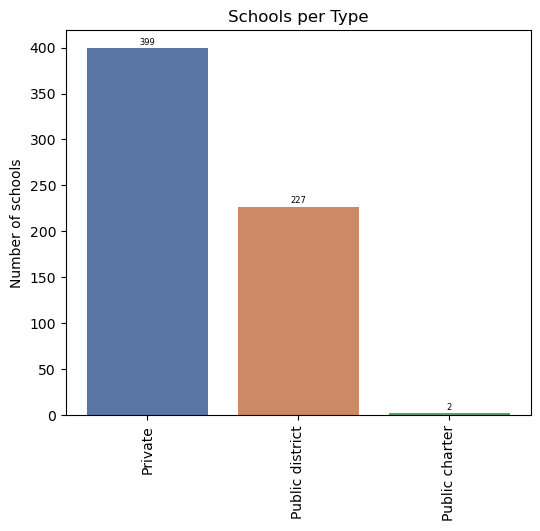

In [50]:
# How many schools are there per type?

# Set the width and height of the figure
plt.figure(figsize=(6,5))
# Add title
plt.title("Schools per Type")
plt.xticks(rotation=90)

ax = sns.countplot(data=schools_df, x='school_type', palette='deep', order=['Private','Public district','Public charter'])
ax.bar_label(container=ax.containers[0], fontsize=6, padding=1)
ax.set(ylabel = 'Number of schools', xlabel='')
ax.plot()

After the pre-processing, we have 399 private schools and 229 public schools (between Public district and Public charter). We'll try to understand with further analyses why there are so many private schools included in this dataset.

### SCHOOL LEVELS

[]

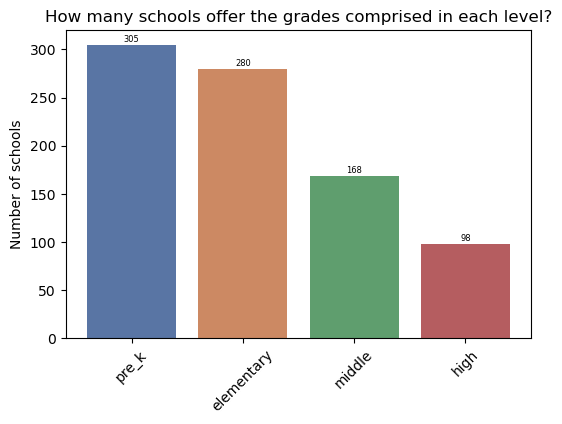

In [52]:
# How many schools offer the grades comprised in each level?

# Get filtered dataset with schools per level
pre_k, elementary, middle, high = get_levels(schools_df)

pre_k_count = pre_k['school_name'].count()
elementary_count = elementary['school_name'].count()
middle_count = middle['school_name'].count()
high_count = high['school_name'].count()

# Set the width and height of the figure
plt.figure(figsize=(6,4))
# Add title
plt.title("How many schools offer the grades comprised in each level?")
plt.xticks(rotation=45)

ax = sns.barplot(x=['pre_k','elementary','middle','high'],y=[pre_k_count,elementary_count,middle_count,high_count], palette='deep')
ax.bar_label(container=ax.containers[0], fontsize=6, padding=1)
ax.set(xlabel = "", ylabel='Number of schools')
ax.plot()

There are more than double the amount of schools that teach elementary grades than those that teach high school grades. It would be interesting to know why the difference is so big, but we don't have information in this dataset to answer that question.


Now, let's see if the number of schools per level is similar in different cities.

[]

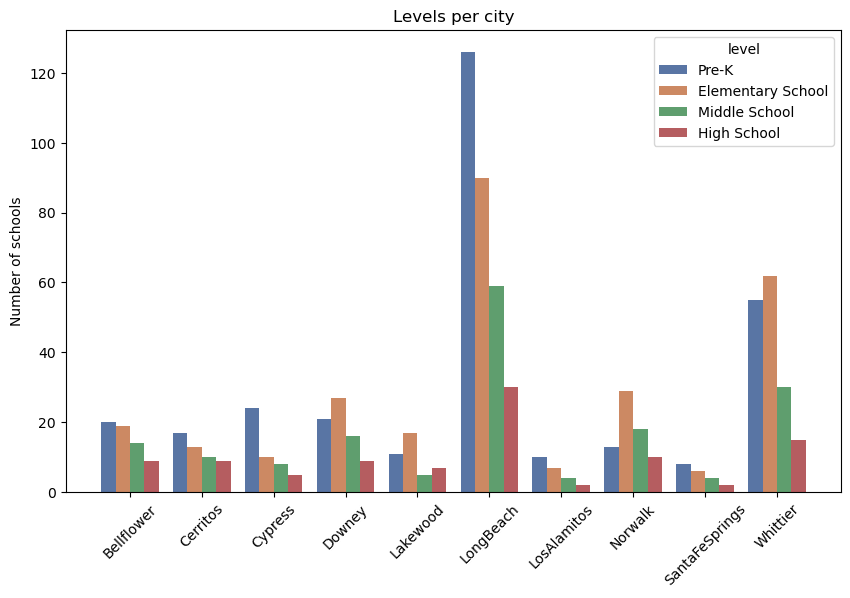

In [53]:
# How are the school levels distributed among the cities?

# Pre-procesing to graph cities and levels together 
pre_k_sum = schools_df.groupby('city')['pre_k_school'].sum()
elementary_sum = schools_df.groupby('city')['elementary_school'].sum()
middle_sum = schools_df.groupby('city')['middle_school'].sum()
high_sum = schools_df.groupby('city')['high_school'].sum()

total_schools_per_city_df = pre_k_sum + elementary_sum + middle_sum + high_sum


levels_city = []
for city in pre_k_sum.index:
    levels_city.append({'city': city,
                       'perc': pre_k_sum[city],#/total_schools_per_city_df[city]*100, 
                       'level': 'Pre-K'})
for city in elementary_sum.index:
    levels_city.append({'city': city,
                       'perc': elementary_sum[city],#/total_schools_per_city_df[city]*100, 
                       'level': 'Elementary School'})

for city in middle_sum.index:
    levels_city.append({'city': city,
                       'perc': middle_sum[city],#/total_schools_per_city_df[city]*100, 
                       'level': 'Middle School'})

for city in high_sum.index:
    levels_city.append({'city': city,
                       'perc': high_sum[city],#/total_schools_per_city_df[city]*100, 
                       'level': 'High School'})

levels_city_df = pd.DataFrame(levels_city)

# Plotting
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Levels per city")

plt.xticks(rotation=45)
ax = sns.barplot(x=levels_city_df['city'],y=levels_city_df['perc'], hue=levels_city_df['level'], palette='deep')
ax.set(xlabel="", ylabel="Number of schools" )
ax.plot()

The first thing we see is that Long Beach and Whittier have many more schools than the rest of the cities.

Regarding levels, there are disparities with some cities like Bellflower, Cerritos, Cypress, Long Beach, Los Alamitos, and Santa Fe Springs having a greater number of institutions offering Pre-K and Kinder, while Downey, Lakewood, Norwalk, and Whittier have more elementary schools. What is constant in every city is that the smallest number of schools corresponds to High Schools.

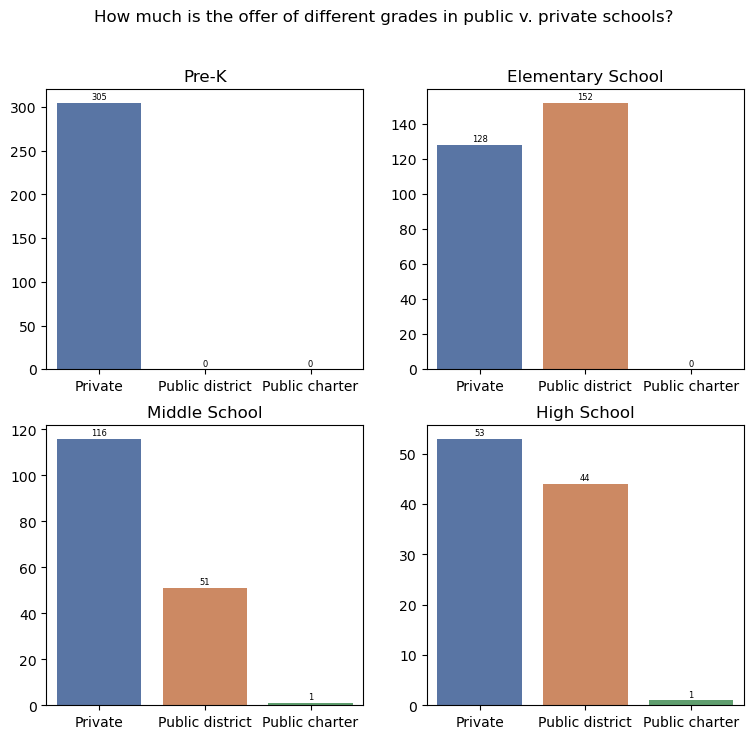

In [102]:
# How much is the offer of different grades in public v. private schools? 

# Get filtered dataset with schools per level
pre_k_df, elementary_df, middle_df, high_df = get_levels(schools_df)

# Initialise the subplot function using number of rows and columns
fig, axes = plt.subplots(2, 2, figsize=(9,8))

fig.suptitle('How much is the offer of different grades in public v. private schools?')

#plt.yticks([100,200,300])
#plt.yticks(['50','100','150','200','250','300'])


sns.countplot(ax=axes[0, 0],data=pre_k_df,      x='school_type', palette='deep', order=['Private','Public district','Public charter'])
sns.countplot(ax=axes[0, 1],data=elementary_df, x='school_type', palette='deep', order=['Private','Public district','Public charter'])
sns.countplot(ax=axes[1, 0],data=middle_df,     x='school_type', palette='deep', order=['Private','Public district','Public charter'])
sns.countplot(ax=axes[1, 1],data=high_df,       x='school_type', palette='deep', order=['Private','Public district','Public charter'])


mult_plot(axes[0,0],'Pre-K', True)
mult_plot(axes[0,1],'Elementary School', True)
mult_plot(axes[1,0],'Middle School', True)
mult_plot(axes[1,1],'High School', True)

plt.show()

We observe that only Private schools offer PK grade, and that there is a greater availability of elementary grades in the Public sector. On the other hand, there are more schools teaching middle grades in Private institutions, but this is affected partially by the fact that some public districts include their middle grades in elementary schools. Now, because grades 9 through 12 are included in the High school level for all insitutions, there is no doubt that there is more offer for this level in the Private sector. 

Bare in mind that it is not possible to sum the schools per type in every level, since each school might include grades from more than one level. 

### SCHOOL SIZE BASED ON TOTAL NUMBER OF STUDENTS

In [37]:
# Create separate dataframes for Private and Public schools
public_s_df = schools_df.loc[(schools_df['school_type'] == 'Public district') | (schools_df['school_type'] == 'Public charter')]
private_s_df = schools_df.loc[(schools_df['school_type'] == 'Private')]

In [38]:
# Missing values in school_total_students
print("Missing values in school_total_students for public schools:", public_s_df['school_total_students'].isnull().sum(),"\n"
      "Missing values in school_total_students for private schools:", private_s_df['school_total_students'].isnull().sum()) 


Missing values in school_total_students for public schools: 0 
Missing values in school_total_students for private schools: 259


The value is missing only in Private schools.

[]

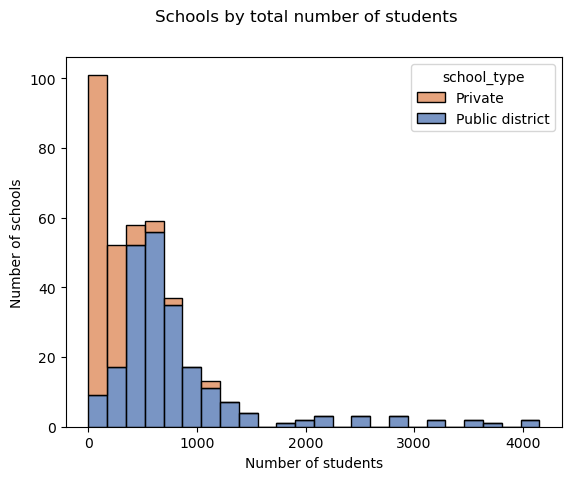

In [64]:
# Plot distribution of 'school_total_students'
total_students_w_data = schools_df.loc[(schools_df['school_total_students'] != 0) & (~schools_df['school_total_students'].isnull()) & (schools_df['school_type'] != 'Public charter')]

# convert the data into a long format
melted_data = pd.melt(total_students_w_data, id_vars='school_type', value_vars='school_total_students')

plt.xlabel('Number of students')
plt.ylabel('Number of schools')
plt.suptitle('Schools by total number of students')
ax = sns.histplot(data=melted_data, x='value', kde=False, binwidth=173, hue='school_type', multiple='stack', hue_order=['Private','Public district'], palette={'Private':'#dd8452','Public district':'#4c72b0'}) #,palette=['blue','orange','green']
ax.plot()

In [54]:
# Descriptive statistics
print(schools_df['school_total_students'].describe())

count     369.000000
mean      562.403794
std       646.406532
min         1.000000
25%       146.000000
50%       414.000000
75%       706.000000
max      4117.000000
Name: school_total_students, dtype: float64


There is data of total students for 369 schools. 

As we see in the plot of the distribution of schools by size and the descriptive statistics, the feature school_total_students corresponds to a positively skewed distribution with a mean of 562.40, a std of 646.40 (very spread out), and a median of 414. The IQR is 560, and a large number of outliers.



[]

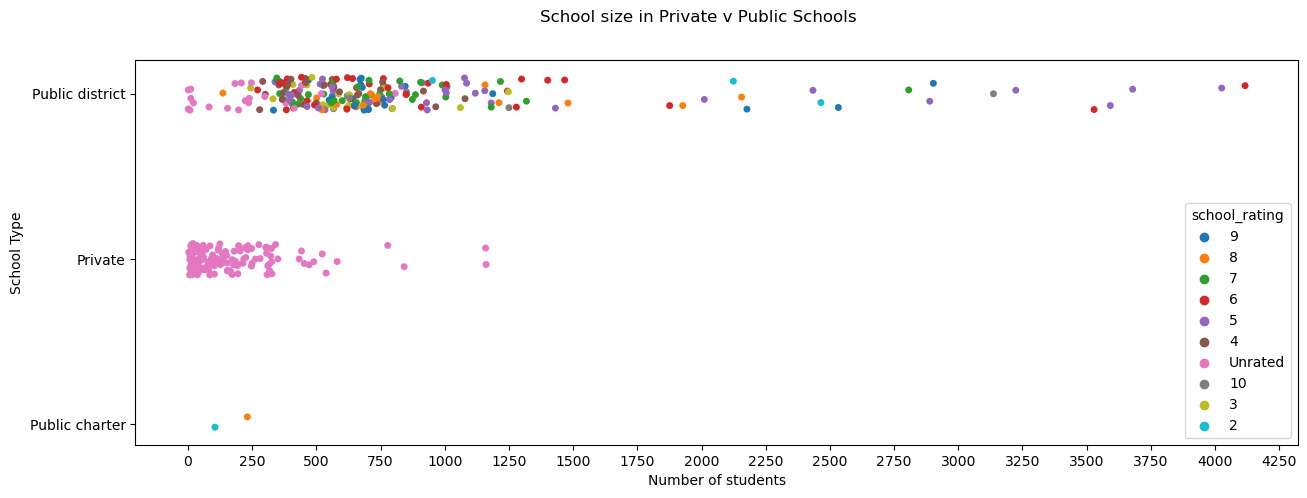

In [55]:
# Does the size of the school varies in private and public schools? Is the rating correlated to the size of the school?

plt.figure(figsize=(15,5))
plt.suptitle('School size in Private v Public Schools')

ax = sns.stripplot(x=schools_df['school_total_students'], y=schools_df['school_type'], hue=schools_df['school_rating'], jitter=True)
#sns.violinplot(ax=axes[1],x=private_s_df['school_total_students'])

ax.set(xlabel="Number of students", ylabel="School Type", xticks=np.arange(0, 4500, step=250))
ax.plot()


In [56]:
# Statistics for private and public schools
print("Private schools:\n",
      "Mean", round(private_s_df['school_total_students'].mean(),2), "\n",
      "St Dev", round(private_s_df['school_total_students'].std(),2), "\n")
print("Public schools:\n",
      "Mean", round(public_s_df['school_total_students'].mean(),2), "\n",
      "St Dev", round(public_s_df['school_total_students'].std(),2), "\n")

Private schools:
 Mean 163.61 
 St Dev 194.36 

Public schools:
 Mean 806.21 
 St Dev 702.87 



We can see that all Private schools are 'Unrated', so we can't get any conclusions about size impacting rating in this type of institutions. However, we visualize that private schools are much less dispersed than public schools in regards to size, with a mean of 163.61 and a St Dev of 194.36. 

In the Public sector, schools are more spread out in the x axis (number of students), with a mean of 794.32 students and St Dev of 699.47, and although here many learning centers that have a rating, it is hard to observe if school size has an impact on it. We will zoom in using a plot of only public schools. 

[]

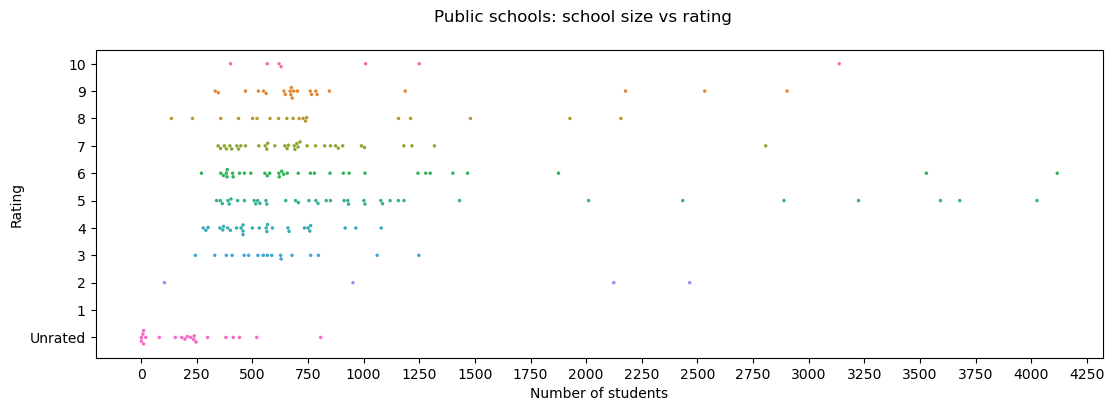

In [58]:
# Is the rating correlated to school size in public schools?

plt.figure(figsize=(13,4))
plt.suptitle('Public schools: school size vs rating')
plt.xticks(rotation=0)
rating_order = ['10','9','8','7','6','5','4','3','2','1','Unrated']

ax = sns.swarmplot(x=public_s_df['school_total_students'], y=public_s_df['school_rating'], hue=public_s_df['school_rating'], order=rating_order, hue_order=rating_order, legend=False, size=2.5)
#sns.violinplot(ax=axes[1],x=private_s_df['school_total_students'])

ax.set(xlabel="Number of students", ylabel="Rating", xticks=np.arange(0, 4500, step=250))
ax.plot()

It is clearer in this graph, that there is no correlation between the rating and the size of the school.

Now, let's see if the total number of students vary in function of the school grades included.

### SCHOOL RATING

We are interested in the school rating, because it will be one of the key features in the selection of good schools for our daughter.

[]

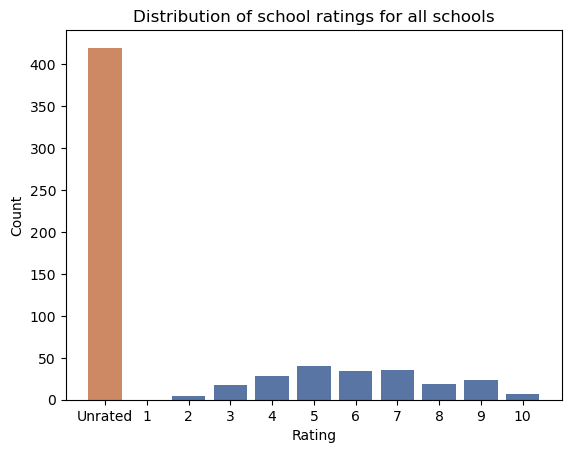

In [65]:
# School rating distribution for all schools

# Add title
plt.title("Distribution of school ratings for all schools")
rating_order = ['Unrated','1','2','3','4','5','6','7','8','9','10']
ax = sns.countplot(data=schools_df,x='school_rating', order=rating_order, palette={'Unrated':'#dd8452','1':'#4c72b0','2':'#4c72b0','3':'#4c72b0','4':'#4c72b0','5':'#4c72b0','6':'#4c72b0','7':'#4c72b0','8':'#4c72b0','9':'#4c72b0','10':'#4c72b0'} )
#schools_df.groupby("school_rating")["school_name"].count().plot.pie(figsize=(6,6), autopct='%1.1f%%', fontsize=6.8,label="", colormap='PuBu', pctdistance=0.75)
ax.set(xlabel='Rating', ylabel='Count')
ax.plot()
#plt.show()

It seems that although School Rating doesn't have missing values, most schools are 'Unrated'. In fact, we already know from previous plots that all private schools are.

Let's disregard 'Unrated' schools and analyze the rating composition of the rated schools.

[]

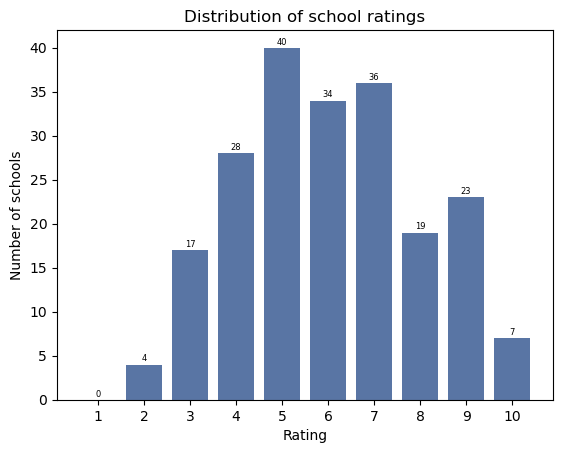

In [71]:
# Rating distribution for rated schools (which includes only Public schools because all Private schools are 'Unrated')

rated_df = schools_df.loc[schools_df['school_rating'] != 'Unrated']

# Add title
plt.title("Distribution of school ratings")

rating_order = ['1','2','3','4','5','6','7','8','9','10']
ax = sns.countplot(data=rated_df,x='school_rating', order=rating_order, color='#4c72b0') #, palette='Blue',
#rated_df.groupby("school_rating")["school_name"].count().plot.pie(figsize=(6,6),autopct='%1.1f%%',fontsize=6.8,label="", colormap='PuBu', pctdistance=0.75)
#ax.set(xlabel='Rating', ylabel='Count')
ax.bar_label(container=ax.containers[0], fontsize=6, padding=1)
plt.xlabel("Rating")
plt.ylabel("Number of schools")
ax.plot()
#plt.show()



Of the rated schools, the most predominant value is 5, and the ratings seem to follow a somewhat Normal distribution. 

Now, let's try to visualize if the ratings are similar among different school levels.


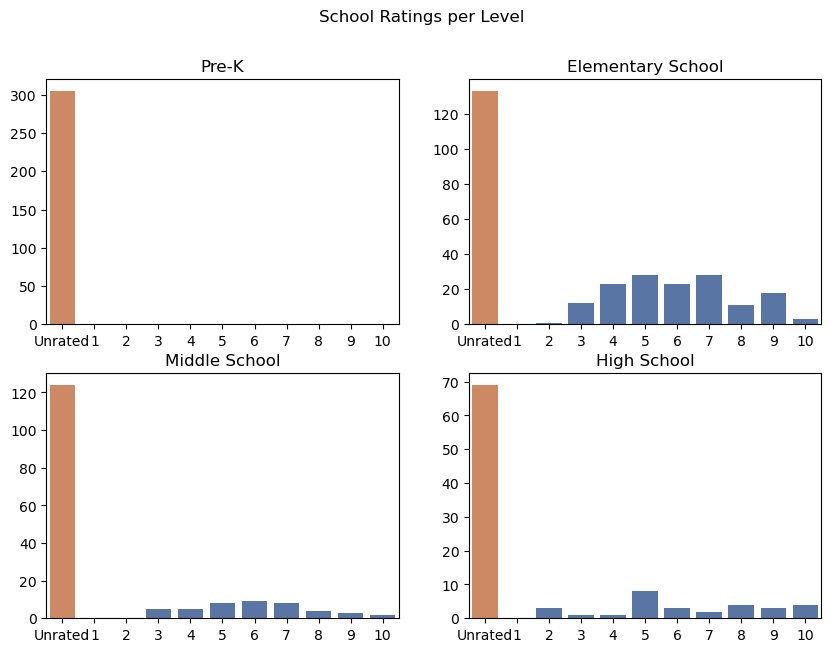

In [103]:
# Rating per level

# Get filtered dataset with schools per level
pre_k_df, elementary_df, middle_df, high_df = get_levels(schools_df)

# Initialise the subplot function using number of rows and columns
fig, axes = plt.subplots(2, 2, figsize=(10,7))

fig.suptitle('School Ratings per Level')

rating_order = ['Unrated', '1','2','3','4','5','6','7','8','9','10']

#pre_k_df.groupby("school_rating")["school_name"].count().plot.pie(ax=axes[0, 0],figsize=(10,10),autopct='%1.1f%%',fontsize=7) #autopct='%1.1f%%',
#elementary_df.groupby("school_rating")["school_name"].count().plot.pie(ax=axes[0,1],figsize=(10,10),autopct='%1.1f%%',fontsize=7)
#middle_df.groupby("school_rating")["school_name"].count().plot.pie(ax=axes[1,0],figsize=(10,10),autopct='%1.1f%%',fontsize=7)
#high_df.groupby("school_rating")["school_name"].count().plot.pie(ax=axes[1,1],figsize=(10,10),autopct='%1.1f%%',fontsize=7)

sns.countplot(ax=axes[0, 0],data=pre_k_df,      x='school_rating',  order=rating_order, palette={'Unrated':'#dd8452','1':'#4c72b0','2':'#4c72b0','3':'#4c72b0','4':'#4c72b0','5':'#4c72b0','6':'#4c72b0','7':'#4c72b0','8':'#4c72b0','9':'#4c72b0','10':'#4c72b0'} ) #palette='flare'
sns.countplot(ax=axes[0, 1],data=elementary_df, x='school_rating',  order=rating_order, palette={'Unrated':'#dd8452','1':'#4c72b0','2':'#4c72b0','3':'#4c72b0','4':'#4c72b0','5':'#4c72b0','6':'#4c72b0','7':'#4c72b0','8':'#4c72b0','9':'#4c72b0','10':'#4c72b0'})
sns.countplot(ax=axes[1, 0],data=middle_df,     x='school_rating',  order=rating_order, palette={'Unrated':'#dd8452','1':'#4c72b0','2':'#4c72b0','3':'#4c72b0','4':'#4c72b0','5':'#4c72b0','6':'#4c72b0','7':'#4c72b0','8':'#4c72b0','9':'#4c72b0','10':'#4c72b0'})
sns.countplot(ax=axes[1, 1],data=high_df,       x='school_rating',  order=rating_order, palette={'Unrated':'#dd8452','1':'#4c72b0','2':'#4c72b0','3':'#4c72b0','4':'#4c72b0','5':'#4c72b0','6':'#4c72b0','7':'#4c72b0','8':'#4c72b0','9':'#4c72b0','10':'#4c72b0'})

mult_plot(axes[0,0],'Pre-K', False)
mult_plot(axes[0,1],'Elementary School', False)
mult_plot(axes[1,0],'Middle School', False)
mult_plot(axes[1,1],'High School', False)

plt.show()

The most rated schools are the ones that contain elementary grades. None of the schools that include PK are rated because they are all Private schools (are there is no rating for any of them). For middle and public schools there is not a lot of difference in the ratings obtained.

### TEST SCORES

In [74]:
# Filter data set to obtain schools with test scores in every subject and obtain descriptive statistics
schools_w_tests = schools_df.loc[~((schools_df['Math'].isnull()) | (schools_df['Science'].isnull()) | (schools_df['English'].isnull()) )]
schools_w_tests[['Math','Science','English']].describe()

,Math,Science,English
count,221.000000,221.000000,221.000000
mean,35.773756,30.027149,49.796380
std,20.873067,19.298591,19.277382
min,1.000000,1.000000,4.000000
25%,21.000000,16.000000,35.000000
50%,32.000000,25.000000,48.000000
75%,48.000000,41.000000,65.000000
max,98.000000,93.000000,99.000000


ANALYZE THE RELATIONSHIP BETWEEN TEST SCORES AND RATING

In [75]:
# Keep schools with test scores and rating
schools_w_tests = schools_w_tests.loc[(schools_w_tests['school_rating'] != 'Unrated')]


[]

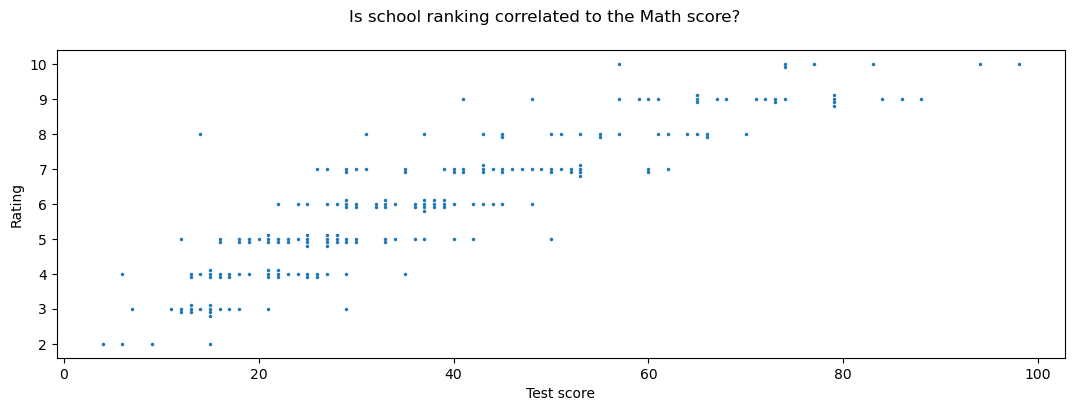

In [78]:
# Is school ranking correlated to the Math score?
plt.figure(figsize=(13,4))
plt.suptitle('Is school ranking correlated to the Math score?')
rating_order = ['10','9','8','7','6','5','4','3','2','1']

ax = sns.swarmplot(x=schools_w_tests['Math'], y=schools_w_tests['school_rating'],  order=rating_order, legend=False, size=2.5) #hue=schools_w_tests['school_rating'],hue_order=rating_order,
#sns.violinplot(ax=axes[1],x=private_s_df['school_total_students'])

ax.set(xlabel="Test score", ylabel="Rating", ) #xticks=np.arange(0, 100, step=10)
ax.plot()

From the scatterplot, it appears that positive correlation exists between the test score obtained in Math and the rating of the school. We will run a Pearson Correlation Test to validate.

In [80]:
# Run a Pearson Correlation Test between school_rating and Math score
f_statistic, p_value = scipy.stats.pearsonr(schools_w_tests['Math'],pd.to_numeric(schools_w_tests['school_rating']))
print("F_Statistic: {0},P-Value: {1}".format(f_statistic, p_value))

F_Statistic: 0.8845541380314897,P-Value: 1.710633298646881e-69


Our Null Hypothesis: There is no association between the score obtained in Math and the rating of the school.

Since the p-value < 0.05, we reject the Null hypothesis and conclude that there exists a relationship between Math score and school rating. Since the correlation coeficient value is 0.88 (very close to 1), it shows a strong positive relationship.

In [83]:
# Another option would have been to run a regression in place of correlation, which we can see obtains very similar results 
# X is the input variables (or independent variables)
X = schools_w_tests[['Math']]
# y is the target/dependent variable
y = pd.to_numeric(schools_w_tests['school_rating'])
# add an intercept (beta_0) to our model
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

#print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          school_rating   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     733.7
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           1.71e-69
Time:                        14:54:16   Log-Likelihood:                -274.65
No. Observations:                 206   AIC:                             553.3
Df Residuals:                     204   BIC:                             559.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7640      0.137     20.186      0.000       2.494       3.034
Math           0.0870      0.003     27.086      0.000       0.081       0.093
==============================================================================
Omnibus:                       21.603   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.255
Skew:                           0.625   Prob(JB):                     9.91e-08
Kurtosis:                       4.481   Cond. No.                         90.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[]

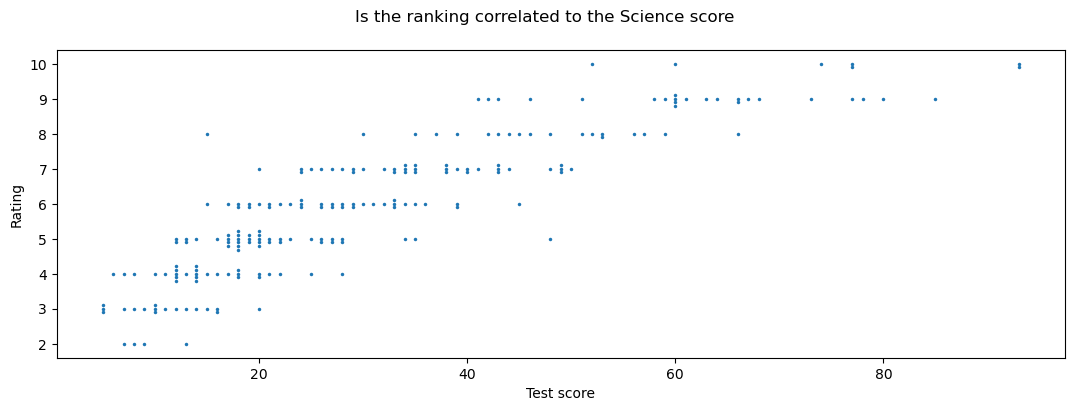

In [85]:
# Is the ranking correlated to the Science score?
plt.figure(figsize=(13,4))
plt.suptitle('Is the ranking correlated to the Science score')
plt.xticks(rotation=0)
rating_order = ['10','9','8','7','6','5','4','3','2','1']

ax = sns.swarmplot(x=schools_w_tests['Science'], y=schools_w_tests['school_rating'],  order=rating_order, legend=False, size=2.5) #hue=schools_w_tests['school_rating'],hue_order=rating_order,
#sns.violinplot(ax=axes[1],x=private_s_df['school_total_students'])

ax.set(xlabel="Test score", ylabel="Rating", ) #xticks=np.arange(0, 100, step=10)
ax.plot()

In [86]:
# Run a Pearson Correlation Test between school_rating and Science score
f_statistic, p_value = scipy.stats.pearsonr(schools_w_tests['Science'],pd.to_numeric(schools_w_tests['school_rating']))
print("F_Statistic: {0},P-Value: {1}".format(f_statistic, p_value))

F_Statistic: 0.8752223013806063,P-Value: 2.8919132949334567e-66


Our Null Hypothesis: There is no association between the score obtained in Science and the rating of the school.

Since the p-value < 0.05, we reject the Null hypothesis and conclude that there exists a relationship between Science score and school rating. Since the correlation coeficient value is 0.87 (very close to 1), it shows a strong positive relationship, which is what we can see in the scatterplot.

Lastly, let's evaluate the correlation between English score and school rating.

[]

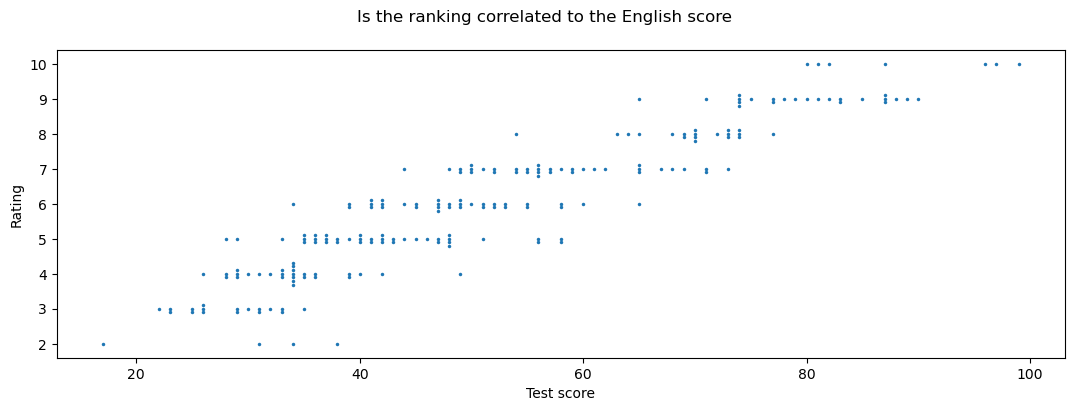

In [88]:
# Is the ranking correlated to the English score?
plt.figure(figsize=(13,4))
plt.suptitle('Is the ranking correlated to the English score')
plt.xticks(rotation=0)
rating_order = ['10','9','8','7','6','5','4','3','2','1']

ax = sns.swarmplot(x=schools_w_tests['English'], y=schools_w_tests['school_rating'], order=rating_order, legend=False, size=2.5) #, hue=schools_w_tests['school_rating'],hue_order=rating_order
#sns.violinplot(ax=axes[1],x=private_s_df['school_total_students'])

ax.set(xlabel="Test score", ylabel="Rating", ) #xticks=np.arange(0, 100, step=10)
ax.plot()

In [89]:
# Run a Pearson Correlation Test between school_rating and Science score
f_statistic, p_value = scipy.stats.pearsonr(schools_w_tests['English'],pd.to_numeric(schools_w_tests['school_rating']))
print("F_Statistic: {0},P-Value: {1}".format(f_statistic, p_value))

F_Statistic: 0.9238019028499533,P-Value: 5.288214657923726e-87


Our Null Hypothesis: There is no association between the score obtained in English and the rating of the school.

Since the p-value < 0.05, we reject the Null hypothesis and conclude that there exists a relationship between English score and school rating. Since the correlation coeficient value is 0.92 (very close to 1 and the largest coeficient of the three subjects), it shows a strong positive relationship, which we can observe in the scatterplot.

Up to this point, the best predictors of the school raking are the school test scores.

### CITY

[]

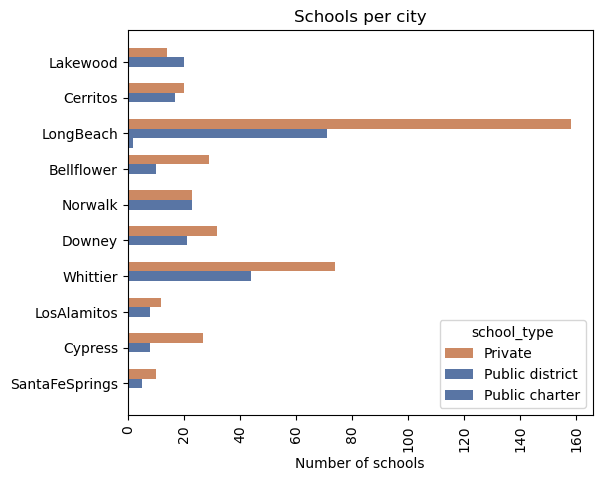

In [105]:
# How are public and private schools distributed among the different cities?

# Set the width and height of the figure
plt.figure(figsize=(6,5))
# Add title
plt.title("Schools per city")
plt.xticks(rotation=90)
ax = sns.countplot(y=schools_df['city'], hue_order=['Private','Public district','Public charter'],hue=schools_df['school_type'], palette={'Private':'#dd8452','Public district':'#4c72b0','Public charter':'#4c72b0'}) #palette='dark:#5A9_r'

ax.set(ylabel = "", xlabel='Number of schools')
ax.plot()

As seen in a previous plot, Long Beach and Whittier are the cities with more schools. 

Lakewood is the only one with more public than private schools, where as Long Beach, Bellflower, and Cypress have more than double the amount of private schools. Also, Long Beach is the only city where charter schools are present.

It is surprinsing to see that almost every city have more private schools, so let's deep dive and see how the distribution changes if we remove the institutions that have only PK or PK-K grades, which we know to be all private. 

[]

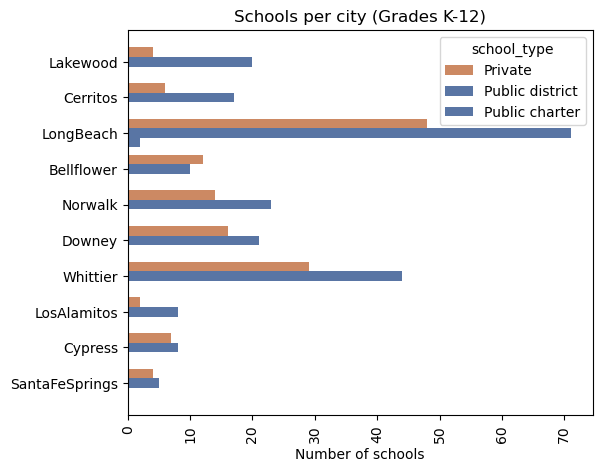

In [99]:
# School distribution per cities (without PK exclusive schools because all of them are Private)

# Remove schools that are only Preschools because they are all private
aux = schools_df.loc[~((schools_df['pre_k_school'] == True) & (schools_df['elementary_school'] == False))]
# Set the width and height of the figure
plt.figure(figsize=(6,5))
# Add title
plt.title("Schools per city (Grades K-12)")
plt.xticks(rotation=90)
ax = sns.countplot(y=aux['city'], hue=aux['school_type'], hue_order=['Private','Public district','Public charter'], palette={'Private':'#dd8452','Public district':'#4c72b0','Public charter':'#4c72b0'})
ax.set(ylabel = "", xlabel='Number of schools')

ax.plot()

The plot changes a lot. Now, we visualize that all cities except for Bellflower have more public than private schools. 

In [106]:
# How does the rating vary per city?
aux = schools_df.loc[schools_df['school_rating'] != 'Unrated'].copy()
aux['school_rating']= aux['school_rating'].apply(lambda x: pd.to_numeric(x))
grouped_df = aux.groupby(['city'])['school_rating'].describe()
grouped_df.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
LosAlamitos,8.0,9.000000,0.755929,8.0,8.75,9.0,9.25,10.0
Cypress,8.0,8.500000,0.925820,7.0,8.00,8.5,9.00,10.0
Cerritos,15.0,8.333333,1.397276,5.0,8.00,9.0,9.00,10.0
SantaFeSprings,5.0,6.400000,1.140175,5.0,6.00,6.0,7.00,8.0
Whittier,39.0,5.923077,1.676221,3.0,4.50,6.0,7.00,9.0
Lakewood,19.0,5.894737,1.410072,4.0,5.00,6.0,7.00,9.0
Downey,18.0,5.777778,1.165966,3.0,5.00,6.0,7.00,7.0
LongBeach,68.0,5.558824,2.032441,2.0,4.00,5.0,7.00,10.0
Norwalk,21.0,4.904762,1.513432,3.0,4.00,4.0,6.00,7.0


[]

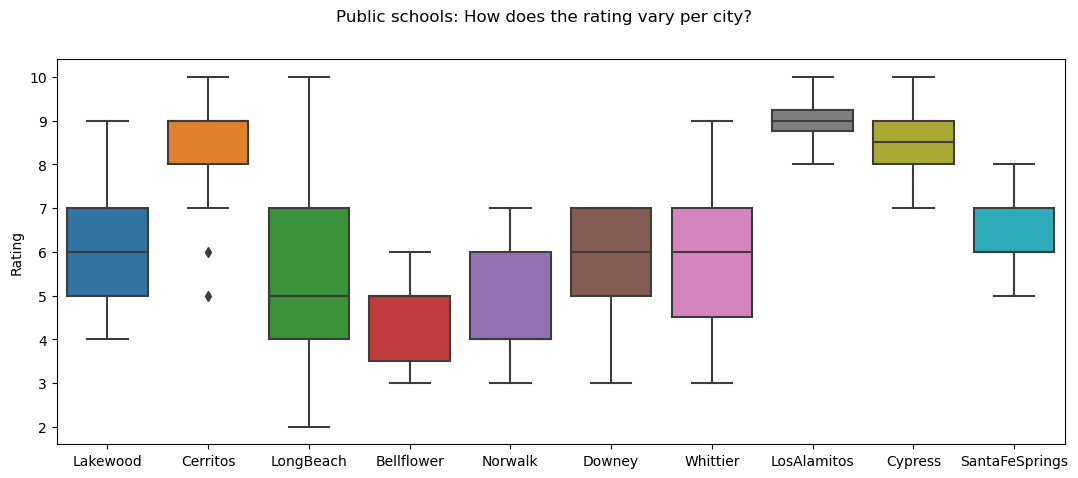

In [108]:
# Plot rating per cities
aux = schools_df.loc[schools_df['school_rating'] != 'Unrated'].copy()
aux['school_rating'] = pd.to_numeric(aux['school_rating'])
plt.figure(figsize=(13,5))
plt.suptitle('Public schools: How does the rating vary per city?')
plt.xticks(rotation=0)
rating_order = ['10','9','8','7','6','5','4','3','2','1']

ax = sns.boxplot(x=aux['city'], y=aux['school_rating']) #hue=schools_df['school_rating'],hue_order=rating_order, order=rating_order,,  size=2.5
#sns.violinplot(ax=axes[1],x=private_s_df['school_total_students'])

ax.set(xlabel="", ylabel="Rating", ) #xticks=np.arange(0, 100, step=10)
ax.plot()

It is clear that some cities like Los Alamitos, Cypress, and Cerritos have better ratings throughout their public school system (remember that private schools didn't have ratings in this dataset). 

In [109]:
# What are the average test scores per city?
schools_w_tests = schools_df.loc[~((schools_df['Math'].isnull()) | (schools_df['Science'].isnull()) | (schools_df['English'].isnull()) )]
grouped_df = schools_w_tests.groupby(['city'])[['English','Math','Science']].agg([np.mean, np.std]) 
grouped_df.sort_values(by=[('English','mean')],ascending=False)

English                  Math               Science  \
                     mean        std       mean        std       mean   
city                                                                    
LosAlamitos     81.750000   6.475228  73.250000  13.519827  62.500000   
Cypress         72.625000  13.048673  64.250000  15.800090  60.250000   
Cerritos        68.058824  23.810372  54.294118  26.100203  51.764706   
SantaFeSprings  54.600000  10.237187  33.200000   3.768289  26.600000   
Lakewood        48.300000  13.958962  29.750000  16.644503  26.400000   
LongBeach       47.295775  19.258686  33.507042  20.147934  27.042254   
Whittier        46.232558  16.441581  32.372093  17.390505  26.837209   
Downey          45.611111  11.146822  31.833333  12.205351  24.166667   
Norwalk         41.181818  11.774211  27.227273  11.152330  21.954545   
Bellflower      33.444444  12.380540  19.888889  11.229920  13.444444   

                           
                      std  
city                       
LosAlamitos     10.184021  
Cypress         19.366761  
Cerritos        24.480935  
SantaFeSprings   3.911521  
Lakewood        12.231968  
LongBeach       18.771130  
Whittier        13.615345  
Downey           8.326075  
Norwalk         10.508397  
Bellflower       7.485171

We already know the test scores are positively correlated to the ratings, so it is expected to see this result where the first three cities with the best scores coincide with the first three with best rating. There are some small disparities in the middle of the table, but the overall result is similar.

#### Visualizing schools in a map

Let's see how are the schools distributed in a map of the area.

In [110]:
# Plot schools Geopoints in a map
# using folium library, using leaflet.js to create a typical map on the top of OpenStreetMap

# Keep only schools with lat, lon data
school_w_address = schools_df.loc[~schools_df['lat'].isnull()]

fig = Figure(width=600, height=400)

# Create a map object and center it to the avarage coordinates to m
m = folium.Map(location=school_w_address[["lat", "lon"]].mean().to_list(), zoom_start=10.5, width='100%', height='100%')

# if the points are too close to each other, cluster them, create a cluster overlay with MarkerCluster, add to m
marker_cluster = MarkerCluster().add_to(m)

# draw the markers and assign popup and hover texts
# add the markers the the cluster layers so that they are automatically clustered
for i,r in school_w_address.iterrows():
    location = (r["lat"], r["lon"])
    concat_tooltip = str(r['school_name'])+ " " + str(r['school_rating'])
    folium.Marker(location=location,
                  popup = r['school_name'],
                  tooltip=concat_tooltip)\
    .add_to(marker_cluster)
# display the map
#m
fig.add_child(m)

#map1 = folium.Map(
#    location=[59.338315,18.089960],
#    tiles='cartodbpositron',
#    zoom_start=12,
#)
#df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
#map1

### STUDENT TEACHER RATIO

In [111]:
# Values in school_teacher_ratio feature
schools_df['school_teacher_ratio'].unique()

array(['21:1', 'Unknown', '30:1', '24:1', '20:1', '25:1', '22:1', '27:1',
       '19:1', '23:1', '32:1', '26:1', '9:1', '29:1', '68:1', '15:1',
       '18:1', '12:1', '34:1', '13:1', '31:1', '28:1', '4:1', '17:1',
       '14:1', '16:1', '6:1', '8:1', '1:1', '11:1', '64:1'], dtype=object)

In [112]:
# Check if Private schools have information about student-teacher ratio
private_s_df = schools_df.loc[(schools_df['school_type'] == 'Private')]
private_s_df['school_teacher_ratio'].unique()

array(['Unknown'], dtype=object)

Because the teacher-student ratio is 'Unknown' for every private school, we'll proceed to explore public schools only.

[]

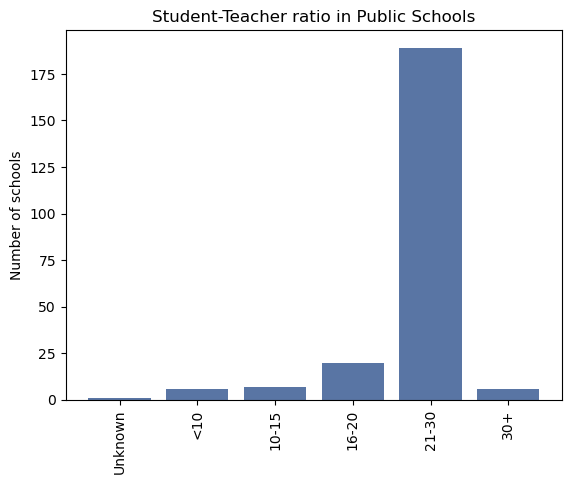

In [118]:
# What is the Teacher-student Ratio for Public Schools?
public_s_df = schools_df.loc[(schools_df['school_type'] == 'Public district') | (schools_df['school_type'] == 'Public charter') ]

# Add title
plt.title("Student-Teacher ratio in Public Schools")
plt.xticks(rotation=90)

ratio_order = ['Unknown','<10','10-15','16-20','21-30','30+']
ax = sns.countplot(data=public_s_df, x='ratio_bins', color='#4c72b0',  order=ratio_order)
ax.set(xlabel='', ylabel='Number of schools')
ax.plot()

The great majority of public schools have a student-teacher ratio of 21 to 30.

### SCHOOL DISTRICTS

In [119]:
# What are the school districts per city and how many schools are included in each one?
public_s_df   = schools_df.loc[schools_df['school_type'] != 'Private']
grouped_df = public_s_df.groupby(['city','school_district'])['school_name'].agg([len])
grouped_df.rename(columns={'len':'count'}, inplace=True)
#pd.set_option('display.max_rows', 500)
grouped_df


count
city           school_district                                     
Bellflower     Bellflower Unified School District                10
Cerritos       Abc Unified School District                       17
Cypress        Anaheim Union High School District                 3
               Cypress Elementary School District                 5
Downey         Downey Unified School District                    21
Lakewood       Abc Unified School District                        5
               Bellflower Unified School District                 5
               Long Beach Unified School District                 8
               Paramount Unified School District                  2
LongBeach      Long Beach Unified School District                72
               Paramount Unified School District                  1
LosAlamitos    Los Alamitos Unified School District               8
Norwalk        Little Lake City Elementary School District        6
               Norwalk-La Mirada Unified School District         17
SantaFeSprings Little Lake City Elementary School District        3
               Los Nietos School District                         1
               Whittier Union High School District                1
Whittier       East Whittier City Elementary School District     13
               Los Nietos School District                         2
               Lowell Joint School District                       3
               Norwalk-La Mirada Unified School District          1
               South Whittier Elementary School District          6
               Whittier City Elementary School District          13
               Whittier Union High School District                6

In [120]:
# What is the average rating per school district?
public_s_df = public_s_df.loc[public_s_df['school_rating'] != 'Unrated']
public_s_df['school_rating'] = public_s_df['school_rating'].apply(lambda x: pd.to_numeric(x))
grouped_df = public_s_df.groupby(public_s_df['school_district'])['school_rating'].agg([np.mean, np.std, min, max, len]) #.apply(lambda x: round(x))
grouped_df.rename(columns={'mean':'avg_rating', 'len':'number_schools'}, inplace=True)
grouped_df.sort_values(by='avg_rating',ascending=False)

,avg_rating,std,min,max,number_schools
school_district,,,,,
Anaheim Union High School District,9.000000,1.000000,8,10,3
Los Alamitos Unified School District,9.000000,0.755929,8,10,8
Cypress Elementary School District,8.200000,0.836660,7,9,5
Abc Unified School District,7.500000,1.933091,4,10,20
Whittier Union High School District,7.400000,1.140175,6,9,5
East Whittier City Elementary School District,6.769231,1.363442,4,9,13
Lowell Joint School District,6.666667,1.527525,5,8,3
Little Lake City Elementary School District,6.444444,0.726483,5,7,9
Los Nietos School District,6.333333,0.577350,6,7,3


## FINDING GOOD SCHOOLS

We are interested in public elementary schools with a rating of 7+ and a demographic composition of at least 25% Hispanics, but not more than 70% (we want our etniticy to be represented, but also appreciate cultural diversity) that are close to a specific location.

In [121]:
# Join schools_df with demographics_df
schools_df = schools_df.merge(demo_df, how='left', on='school_name') 
schools_df.columns

Index(['city', 'school_name', 'school_rating', 'school_address', 'school_url',
       'school_type', 'school_grades', 'school_total_students',
       'school_teacher_ratio', 'school_district', 'English', 'Math', 'Science',
       'pre_k_school', 'elementary_school', 'middle_school', 'high_school',
       'ratio_bins', 'lat', 'lon', 'altitude', 'Asian', 'Black', 'Filipino',
       'Hispanic', 'Native American', 'Pacific Islander', 'Two or more races',
       'Unspecified', 'White'],
      dtype='object')

In [122]:
# Filter schools based on chosen criteria
good_schools_df = pd.DataFrame()
# Get only public schools
public_s_df = schools_df.loc[(schools_df['school_type'] == 'Public district') | (schools_df['school_type'] == 'Public charter') ].copy()

# Get schools elementary schools with rating of +7 and a Hispanic group of at least 25% and no more than 70%
good_schools_df = public_s_df.loc[public_s_df['school_rating'] != 'Unrated'].copy()
good_schools_df['school_rating'] = good_schools_df['school_rating'].apply(lambda x: pd.to_numeric(x))
good_schools_df = good_schools_df.loc[(good_schools_df['school_rating'] >= 7) & (good_schools_df['elementary_school'] == True) & (good_schools_df['Hispanic'] >= '25%') & (good_schools_df['Hispanic'] <= '70%')]

In [135]:
# Get schools close to a relevant point (for example Granma's house)

good_schools_df['coord'] = list(zip(good_schools_df['lat'], good_schools_df['lon']))
# Define point
important_location = (33.909000, -118.100000)

def distanc(row):
    row['dist'] = geopy.distance.geodesic(important_location, row['coord']).miles

    return row

#good_schools_df['gdf'] = geopandas.GeoDataFrame(good_schools_df,geometry=geopandas.points_from_xy(good_schools_df['lat'],good_schools_df['lon']))
good_schools_df = good_schools_df.apply(distanc, axis='columns') 

good_schools_df = good_schools_df.loc[good_schools_df['dist'] < 5]

In [124]:
# Number of interesting schools
print("Number of good schools to analyze:",good_schools_df.shape[0])

Number of good schools to analyze: 10


In [136]:
# Plot good schools in the map
# Keep only schools with lat, lon data
school_w_address = good_schools_df.loc[(~ good_schools_df['lat'].isnull())]

fig = Figure(width=600, height=400)

# Create a map object and center it to the avarage coordinates to m
m = folium.Map(location=school_w_address[["lat", "lon"]].mean().to_list(), zoom_start=11, width='100%', height='100%')

# if the points are too close to each other, cluster them, create a cluster overlay with MarkerCluster, add to m
marker_cluster = MarkerCluster().add_to(m)

# draw the markers and assign popup and hover texts
# add the markers the the cluster layers so that they are automatically clustered
for i,r in school_w_address.iterrows():
    location = (r["lat"], r["lon"])
    concat_tooltip = str(r['school_name'])+ " " + str(r['school_rating'])
    folium.Marker(location=location,
                  popup = r['school_name'],
                  tooltip=concat_tooltip) \
     .add_to(m)               
    #.add_to(marker_cluster)
# display the map
#m
fig.add_child(m)

In [130]:
# Drop columns and order
aux = good_schools_df.drop(columns=['altitude','school_type','school_url','Pacific Islander','Native American','Two or more races','Unspecified','ratio_bins','pre_k_school', 'elementary_school', 'middle_school', 'high_school', 'coord', 'dist'])
aux.sort_values(by=['school_rating','school_total_students','Math','Science','English'], ascending=[False, True, False, False, False, ])

,city,school_name,school_rating,school_address,school_grades,school_total_students,school_teacher_ratio,school_district,English,Math,Science,lat,lon,Asian,Black,Filipino,Hispanic,White
35,Cerritos,Wittmann (Helen) Elementary School,10,"16801 Yvette Avenue, Cerritos, CA, 90703",K-6,620.0,26:1,Abc Unified School District,87.0,74.0,74.0,33.878112,-118.057171,43%,9%,14%,25%,6%
0,Lakewood,Cleveland Elementary School,9,"4760 Hackett Avenue, Lakewood, CA, 90713",K-5,469.0,21:1,Long Beach Unified School District,77.0,65.0,41.0,33.844133,-118.106698,4%,6%,5%,41%,34%
42,Cerritos,Stowers(Cecil B.) Elementary School,9,"13350 Beach Street, Cerritos, CA, 90703",K-6,670.0,29:1,Abc Unified School District,71.0,65.0,61.0,33.876433,-118.047499,37%,5%,13%,31%,7%
41,Cerritos,Nixon (Patricia) Elementary School,9,"19600 Jacob Avenue, Cerritos, CA, 90703",K-6,785.0,27:1,Abc Unified School District,75.0,67.0,67.0,33.852771,-118.076460,17%,9%,18%,39%,9%
44,Cerritos,Carver (Charles J.) Elementary School,8,"19200 Ely Avenue, Cerritos, CA, 90703",K-6,618.0,26:1,Abc Unified School District,70.0,53.0,46.0,33.856216,-118.068866,16%,14%,15%,45%,6%
43,Cerritos,Bragg Elementary School,8,"11501 Bos Street, Cerritos, CA, 90703",K-6,655.0,27:1,Abc Unified School District,70.0,64.0,59.0,33.856177,-118.089485,17%,10%,25%,33%,6%
5,Lakewood,Macarthur Elementary School,7,"6011 Centralia Street, Lakewood, CA, 90713",K-5,374.0,25:1,Long Beach Unified School District,59.0,53.0,38.0,33.839603,-118.114587,5%,9%,3%,45%,24%
4,Lakewood,Holmes Elementary School,7,"5020 Barlin Avenue, Lakewood, CA, 90712",K-5,383.0,20:1,Long Beach Unified School District,51.0,43.0,24.0,33.849500,-118.147895,6%,36%,5%,34%,5%
2,Lakewood,Stephen Foster Elementary School,7,"5223 Bigelow Street, Lakewood, CA, 90712",K-6,688.0,30:1,Bellflower Unified School District,57.0,44.0,43.0,33.858075,-118.130909,7%,9%,6%,53%,19%
3,Lakewood,Gompers K-8,7,"5206 Briercrest Avenue, Lakewood, CA, 90713",K-8,700.0,24:1,Long Beach Unified School District,52.0,45.0,25.0,33.852289,-118.123041,7%,9%,2%,51%,21%


An so we finally have a list of schools that satisfy our criteria and serve as a guide when choosing the best school for our daughter :)